In [1]:
import pandas as pd
import requests
import json
import prettytable

In [2]:
def request_bls_data(series_id):
    headers = {'Content-type': 'application/json'}
    data_info = json.dumps({"seriesid":[series_id],"startyear":"2002","endyear":"2021",'registrationKey':"6ade8a5701584eb2bc428cfe380355b8"})
    response = requests.post("https://api.bls.gov/publicAPI/v2/timeseries/data/",data=data_info,headers=headers)
    return json.loads(response.text) 


def parse_bls_data(json_response):
#     print(json.dumps(json_response, indent=4, sort_keys=False))
    results = []
    for series in json_response['Results']['series']:
        series_id = series['seriesID']
        for item in series['data']:
            entity={}
            entity['year'] = item['year']
            entity['period'] = item['period']
            entity['value'] = item['value']
            results.append(entity)
    return pd.DataFrame(results)


def preprocess_data():
    pass

In [3]:
cpi_series_id = "CUUR0000SA0"
cpi_dataset = parse_bls_data(request_bls_data(cpi_series_id))
cpi_dataset.to_csv("../datasets/BLS_CPI.csv")
cpi_dataset.shape

(233, 3)

In [4]:
cpi_dataset.head()

,year,period,value
0,2021,M05,269.195
1,2021,M04,267.054
2,2021,M03,264.877
3,2021,M02,263.014
4,2021,M01,261.582


In [5]:
cpi_dataset['date'] = cpi_dataset.apply(lambda x: x[0]+"-"+x[1].replace("M",""),axis=1)
cpi_dataset['CPI'] = cpi_dataset[['value']].apply(pd.to_numeric)
cpi_dataset = cpi_dataset[['date','CPI']]
# cpi_dataset.columns = 'Date','CPI'
cpi_dataset

,date,CPI
0,2021-05,269.195
1,2021-04,267.054
2,2021-03,264.877
3,2021-02,263.014
4,2021-01,261.582
...,...,...
228,2002-05,179.800
229,2002-04,179.800
230,2002-03,178.800
231,2002-02,177.800


In [6]:
cpi_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    233 non-null    object 
 1   CPI     233 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.8+ KB


In [7]:
cpi_dataset = cpi_dataset.iloc[::-1]
cpi_dataset

,date,CPI
232,2002-01,177.100
231,2002-02,177.800
230,2002-03,178.800
229,2002-04,179.800
228,2002-05,179.800
...,...,...
4,2021-01,261.582
3,2021-02,263.014
2,2021-03,264.877
1,2021-04,267.054


In [8]:
wsp_series_id = "CIU2020000000000A"
wsp_dataset = parse_bls_data(request_bls_data(wsp_series_id))
wsp_dataset.to_csv("../datasets/BLS_WSP.csv")

In [9]:
wsp_dataset.shape

(77, 3)

In [10]:
wsp_dataset = wsp_dataset.iloc[::-1]
wsp_dataset

,year,period,value
76,2002,Q01,3.5
75,2002,Q02,3.6
74,2002,Q03,3.1
73,2002,Q04,2.6
72,2003,Q01,2.9
...,...,...,...
4,2020,Q01,3.3
3,2020,Q02,2.9
2,2020,Q03,2.7
1,2020,Q04,2.8


In [11]:
wsp_dataset['date'] = wsp_dataset.apply(lambda x: x[0]+x[1].replace("0",""),axis=1)
wsp_dataset['wages'] = wsp_dataset[['value']].apply(pd.to_numeric)
wsp_dataset = wsp_dataset[['date','wages']]
# wsp_dataset.columns = 'date','wages'
wsp_dataset.head()

,date,wages
76,2002Q1,3.5
75,2002Q2,3.6
74,2002Q3,3.1
73,2002Q4,2.6
72,2003Q1,2.9


In [12]:
wsp_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 76 to 0
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    77 non-null     object 
 1   wages   77 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.3+ KB


In order to combine wages-salaries dataset with the CPI dataset, transform date in order to have same format. WSP dataset is in quarters, (not monthly).


In [13]:
cpi_dataset['date'] = cpi_dataset['date'].str.replace('-03','Q1')
cpi_dataset['date'] = cpi_dataset['date'].str.replace('-06','Q2')
cpi_dataset['date'] = cpi_dataset['date'].str.replace('-09','Q3')
cpi_dataset['date'] = cpi_dataset['date'].str.replace('-12','Q4')

In [14]:
cpi_dataset

,date,CPI
232,2002-01,177.100
231,2002-02,177.800
230,2002Q1,178.800
229,2002-04,179.800
228,2002-05,179.800
...,...,...
4,2021-01,261.582
3,2021-02,263.014
2,2021Q1,264.877
1,2021-04,267.054


In [15]:
# remove the rows containing data for rest of the months
newcpi = cpi_dataset[(cpi_dataset.date.str.contains("-") == False)]
newcpi.shape

(77, 2)

as the data in CPI dataset comes in absolute point value, while the values given in WSP dataset are  wages reported in percentages measuring growth, as there's no way to accurately compare them.

when we're told that the rate for the first quarter of 2002 was 3.5%.

That means that if wages continued to rise at the current first quarter rate, for a full 12 months, the annual average growth would have been 3.5%, but not 14%, which means the numbers we're going to work with will have to be adjusted.

That's because the actual growth during say the three months of 2002, quarter one wasn't 3.5%, but only a quarter of that, or 0.8 75%.

In [16]:
# wsp_dataset = wsp_dataset.apply(pd.to_numeric)
wsp_dataset.tail()

,date,wages
4,2020Q1,3.3
3,2020Q2,2.9
2,2020Q3,2.7
1,2020Q4,2.8
0,2021Q1,3.0


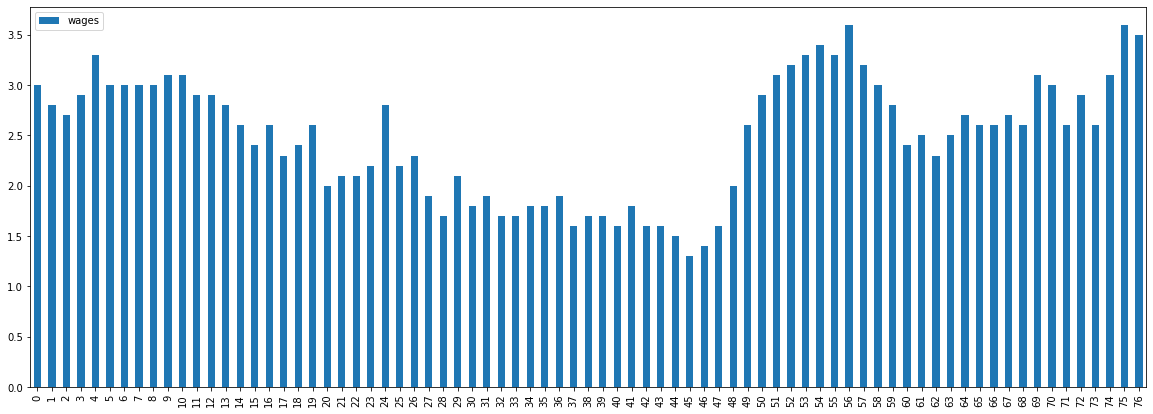

In [17]:
ax = wsp_dataset.plot(kind='bar',figsize=(20,7))

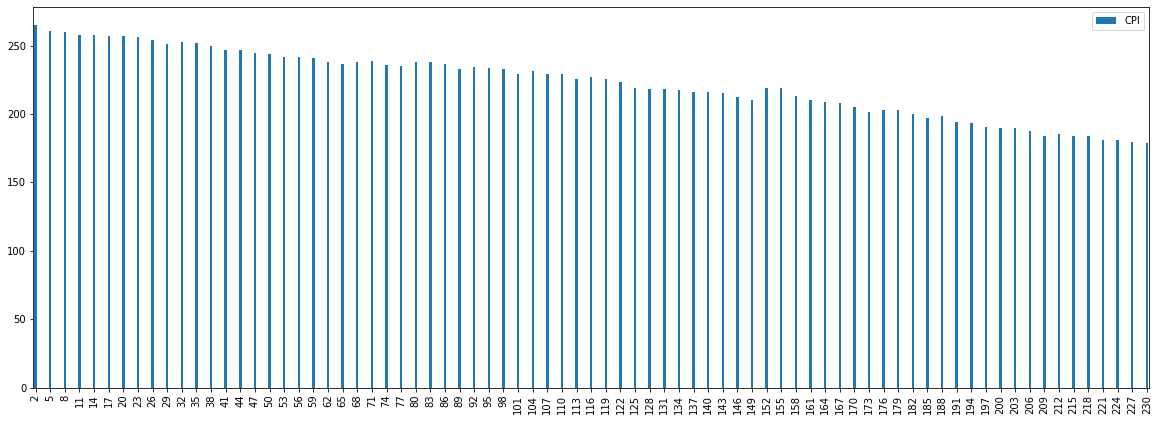

In [18]:
ax = newcpi.plot(kind='bar',figsize=(20,7))


In [19]:
newnum = 178.8
def process_wages(x):
    global newnum
    if type(x) is str:
        return x
    elif x:
        newnum = (x/400)*newnum + newnum
        return newnum
    else:
        return
    
newwages = wsp_dataset.applymap(process_wages)

<AxesSubplot:>

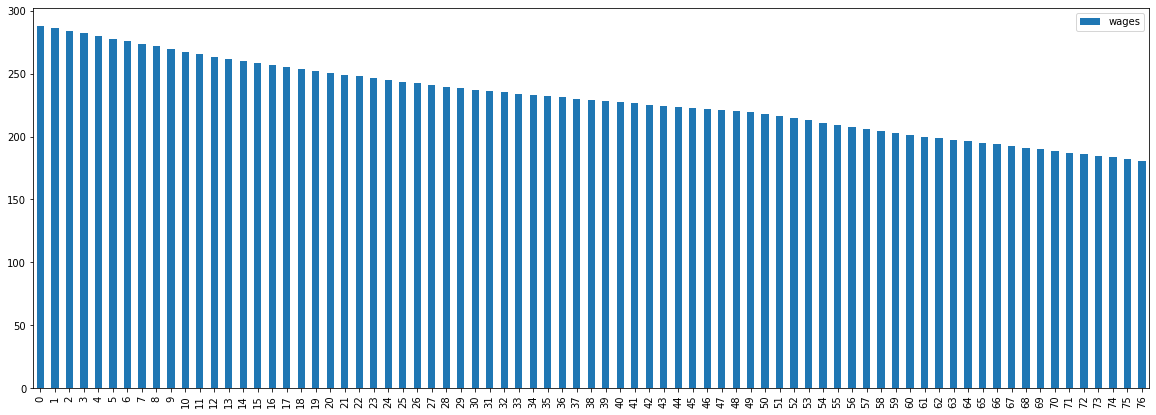

In [20]:
newwages.plot(kind='bar',figsize=(20,7))


In [21]:
newwages

,date,wages
76,2002Q1,180.364500
75,2002Q2,181.987781
74,2002Q3,183.398186
73,2002Q4,184.590274
72,2003Q1,185.928553
...,...,...
4,2020Q1,280.073663
3,2020Q2,282.104197
2,2020Q3,284.008401
1,2020Q4,285.996459


### Merging Pandas dataframes and Plotting Data

In [22]:
merged_data = pd.merge(newcpi,newwages,on='date')
merged_data.shape

(77, 3)

In [23]:
merged_data.head()

,date,CPI,wages
0,2002Q1,178.8,180.364500
1,2002Q2,179.9,181.987781
2,2002Q3,181.0,183.398186
3,2002Q4,180.9,184.590274
4,2003Q1,184.2,185.928553


Text(0, 0.5, 'CPI vs Wages and salaries: 12-month change')

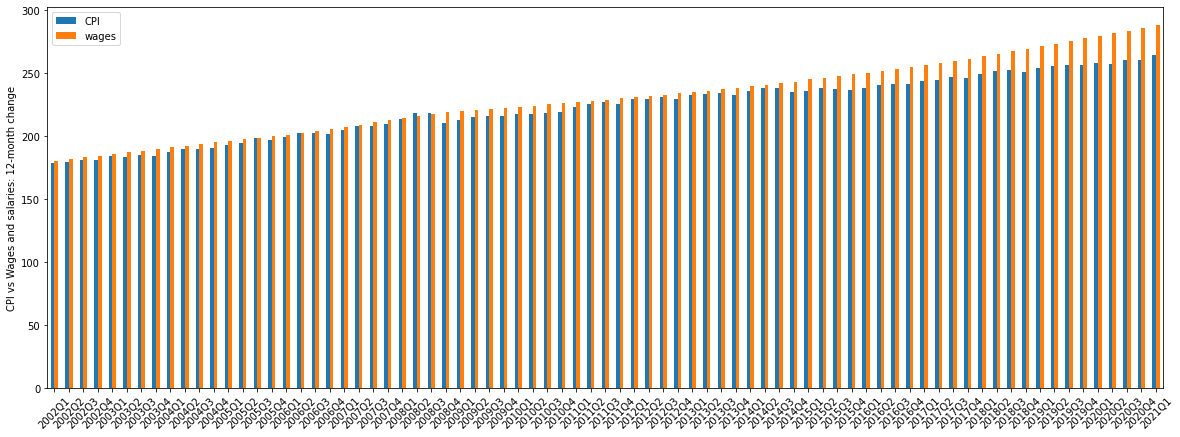

In [24]:
ax = merged_data.plot(kind='bar',figsize=(20,7))
ax.set_xticklabels(merged_data.date,rotation = 45)
ax.set_ylabel('CPI vs Wages and salaries: 12-month change')

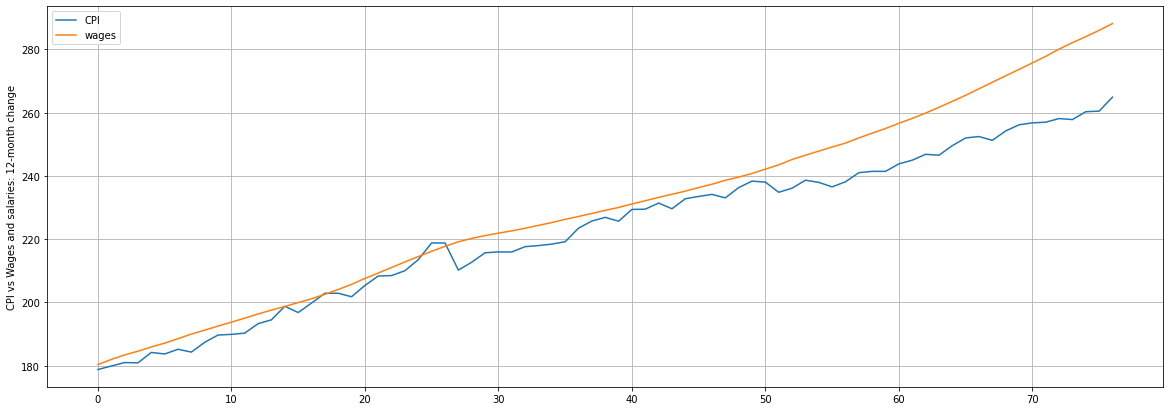

In [25]:
ax= merged_data.plot(kind = 'line',figsize=(20,7))
ax.set_ylabel('CPI vs Wages and salaries: 12-month change')
ax.grid()

#### conclusion:  There is a continuous increase in the consumer price index as well as the wages of private sector labrour in United states.